<a href="https://colab.research.google.com/github/smartaces/OpenAI_Audio_Model_Cookbooks/blob/main/OpenAI_Simple_Text_To_Audio_Generator_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Unofficial OpenAI and Short Audio Recording/ Podcast Generator**

*   This notebook provides working code for generating audio files using a variety of OpenAI voice models, including text to speech models and the premium GPT4o voice generation models.

*   With this notebook you will be able to easily create audio recordings of articles using a variety of models, customising the voice and delivery style.

*   You can also generator short audio files of any text files like say study notes - anything you can think of!

This cookbook uses the full range of voice models available as of April 2025.

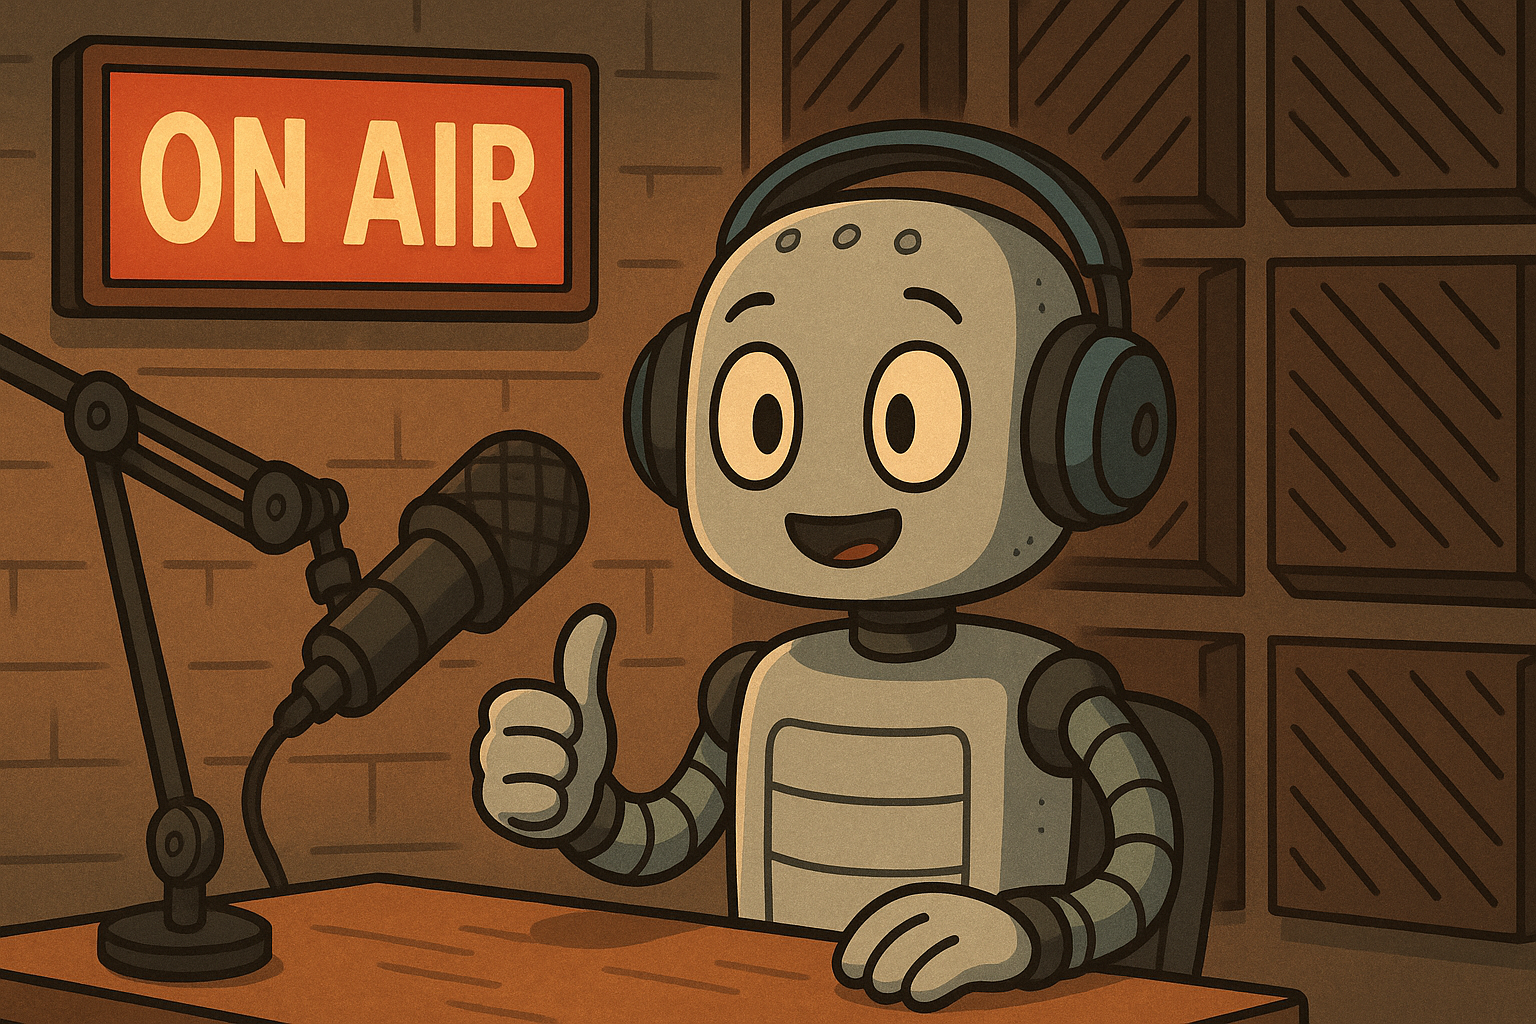

# **Set Your OpenAI API Key**

To use this notebook and build your solution you will need...


*   An OpenAI user account and API Key (with billing set up)
*   As pictured below add this to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following name
*   Key name: openai_key
*   Once that is done, run the below cell link text granting key access to the notebook access if prompted




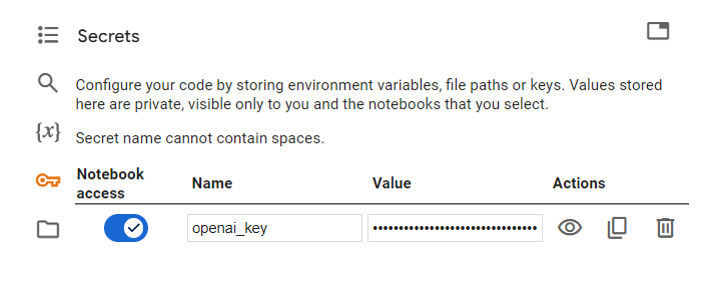


# **Step1: Installs OpenAI python library**

First we need to install the OpenAI python Library

In [ ]:
# @title
!pip install openai --quiet
!pip install openai[voice_helpers] --quiet
!pip install tiktoken --quiet

# **Load Your API Key**

This loads and sets up your OpenAI key, make sure you have added it to your Colab secrets as per the instructions above.

In [ ]:
# @title

# First cell - Set up API key using userdata
from openai import OpenAI
from google.colab import userdata

openai_key = userdata.get("openai_key")
if not openai_key:
    raise ValueError("No OpenAI API key found. Please set openai_key in Colab > 'Table of contents' > 'User snippets'.")

client = OpenAI(api_key=openai_key)
print("OpenAI client initialized.")

# Also set it as an environment variable for later use
import os
os.environ["OPENAI_API_KEY"] = openai_key

# **Please Read: General Guidance and Tips**

This notebook allows you to test and create audio recordings using OpenAI models. There are two versions of the audio generator.

1. Premium voice generation using OpenAI's GPT4o-audio-preview models - this overall responds much more strongly to tone of voice instructions, but is much more expensive to run.

2. Fast and low cost voice generation using  OpenAI's GPT4o text to speech models - these sometimes respond well to instructions but do not seem to obey as strongly or consistently as the GPT4o-audio-preview models.

Finally, for best and most responsive performances choose Ash or Coral voices. They have the greatest range and maleability overall.

# **Load and Test Preview Clips of OpenAI's AI Voices**

This cell loads some mp3 recordings of OpenAI's voices which I prepared for you.

*   From these you can get a sense of which ones you like for use later on

*   These are pre-recorded clips, so you don't have to spend tokens on generating your own test voice samples.

*   Simply select the voice from the dropdown and hit play.

*   Generally Alloy, Ash and Coral are very reliable.

*   These mp3s are saved to a folder called /content/voice_previews

In [ ]:
# @title
import os
import requests
from urllib.parse import urljoin
from IPython.display import display, Audio, clear_output
import ipywidgets as widgets
import io

# Create the target directory if it doesn't exist
target_dir = "/content/voice_previews"
os.makedirs(target_dir, exist_ok=True)

# Base URL for raw GitHub content
base_url = "https://raw.githubusercontent.com/smartaces/OpenAI_Audio_Model_Cookbooks/main/"

# List of file names to download
file_names = [
    "shimmer.mp3",
    "sage.mp3",
    "nova.mp3",
    "onyx.mp3",
    "fable.mp3",
    "echo.mp3",
    "coral.mp3",
    "ballad.mp3",
    "ash.mp3",
    "alloy.mp3"
]

# Download each file
for file_name in file_names:
    # Construct the full URL
    url = urljoin(base_url, file_name)

    # Download the file
    response = requests.get(url)

    # Check if the download was successful
    if response.status_code == 200:
        # Save the file to the target directory
        file_path = os.path.join(target_dir, file_name)
        with open(file_path, "wb") as f:
            f.write(response.content)

# Create a dropdown menu to select MP3 files
dropdown = widgets.Dropdown(
    options=file_names,
    description='Select voice:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Create the player output widget where audio will be displayed
player_output = widgets.Output()

# Function to update the audio player when selection changes
def on_selection_changed(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with player_output:
            # Clear previous audio player
            clear_output(wait=True)
            # Get the selected file
            selected_file = change['new']
            file_path = os.path.join(target_dir, selected_file)
            # Display the audio player without autoplay
            display(Audio(file_path, autoplay=False))

# Register the callback for dropdown changes
dropdown.observe(on_selection_changed, names='value')

# Display the UI components
print("\nSelect a Voice to Preview:\n")
display(dropdown)
print("\n")
display(player_output)

# Trigger initial load of the first audio in the list
with player_output:
    first_file = file_names[0]
    file_path = os.path.join(target_dir, first_file)
    display(Audio(file_path, autoplay=False))

# **Premium Voice Generation with GPT-4o Audio Models**

*   With this code example, you will be able to create short  audio files of any written text (shorter than 16,000 input tokens - approximately 10,000 to 12,000 words or 20-30 pages of single spaced text).

*   For example you can create audio recordings of speaker notes for presentations, exam preparation notes, or even short blog articles.

*   It uses OpenAI's premium voice generation models, which differ slightly from text to speech.

*   There are two models to choose from GPT4o - 80 dollars  per million tokens - or GPT4o-mini - 20 dollars per million tokens.

*   GPT4o is the most responsive to tone of voice instructions, you get the best and most reliable performance, but it is pretty expensive. GPT4o-mini does a pretty good job at tone of voice instruction following. The best advice is to test and find what works best for you.  

*   These models have much larger output length of 16,384 tokens than OpenAI's text to speech models, making them better suited for audio generation of longer written texts.  

*   Interestingly, they sometimes feature audio artifacts or mispronunciations, compared to the TTS models in the other example below.

*   Files are saved to the folder: /content/audio

*   Coral and Ash are the easiest and most responsive voices to tone of voice directions.

In [ ]:
#@title Premium Voice Generation with GPT-4o Audio Models (TikToken Check)
#The gpt-4o-audio-preview model has a context window of 128,000 tokens.
#The model can also generate outputs of up to 16,384 tokens
#text input $0.15 audio output $20 per million tokens
#as of 4/11/2025


import base64
import os
import time
import datetime
from IPython.display import display, HTML, Audio
import ipywidgets as widgets
from openai import OpenAI
import tiktoken  # Import tiktoken for token counting

# Create output directory
output_dir = "/content/audio"
os.makedirs(output_dir, exist_ok=True)

# Define voice options with descriptions
voice_options = [
    ('alloy (Female - Neutral American)', 'alloy'),
    ('ash (Male - More Dramatic American)', 'ash'),
    ('ballad (Male - Dramatic English)', 'ballad'),
    ('coral (Female - More Dramatic American)', 'coral'),
    ('echo (Male - Neutral American)', 'echo'),
    ('fable (Male)', 'fable'),
    ('onyx (Male - Neutral)', 'onyx'),
    ('nova (Female - Neutral)', 'nova'),
    ('sage (Female - More Dramatic American)', 'sage'),
    ('shimmer (Female - Upbeat Neutral)', 'shimmer')
]

# Define example prompts
example_prompts = [
    "A mindfulness coach with a soothing and relaxing voice",
    "A pirate captain with a gruff, deep-voice and dramatic delivery. Use strong pirate inflections and occasional growls",
    "A whispering librarian, who is being very careful to speak in a hushed tone",
    "A cowboy with a slow-paced soothing southern drawl",
    "An eloquent and eccentric IVY League professor with a passionate, theatrical, inspiring, dramatic delivery",
    "A charming morning tv show host with warm, uplifting and happy tone",

]

# Create widgets
text_input = widgets.Textarea(
    placeholder='Enter your prompt or text to be spoken',
    description='Text:',
    layout=widgets.Layout(width='100%', height='150px')
)

voice_dropdown = widgets.Dropdown(
    options=voice_options,
    description='Voice:',
    value='alloy'
)

instruction_input = widgets.Textarea(
    placeholder='Describe the voice (Accent, Emotional range, Intonation, Impressions, Speed of speech, Tone, Whispering, etc.)',
    description='Instructions:',
    layout=widgets.Layout(width='100%', height='80px')
)

example_dropdown = widgets.Dropdown(
    options=['Choose an example...'] + example_prompts,
    description='Examples:',
    value='Choose an example...'
)

model_dropdown = widgets.Dropdown(
    options=[
        ('gpt-4o-mini-audio-preview ($20 per million audio output tokens)', 'gpt-4o-mini-audio-preview'),
        ('gpt-4o-audio-preview ($80 per million audio output tokens)', 'gpt-4o-audio-preview')
    ],
    description='Model:',
    value='gpt-4o-mini-audio-preview'
)

filename_input = widgets.Text(
    value='',
    placeholder='Custom filename (leave empty for timestamp)',
    description='Filename:',
    layout=widgets.Layout(width='100%')
)

submit_button = widgets.Button(
    description='Generate Audio',
    button_style='primary',
    icon='microphone'
)

output_area = widgets.Output()

# Function to count tokens using tiktoken
def count_tokens(text, instructions):
    prompt_text = f"please narrate this {instructions}. DO NOT SAY ANYTHING ELSE, just read the text out loud: {text}" if instructions else text
    # Use cl100k_base encoder which is used for most recent models
    enc = tiktoken.get_encoding("cl100k_base")
    tokens = enc.encode(prompt_text)
    return len(tokens)

# Function to count words
def count_words(text, instructions):
    prompt_text = f"please narrate this {instructions}. DO NOT SAY ANYTHING ELSE, just read the text out loud: {text}" if instructions else text
    # Simple word count by splitting on whitespace
    return len(prompt_text.split())

# Functions for handling example prompt selections
def on_example_change(change):
    if change['new'] != 'Choose an example...':
        instruction_input.value = change['new']
        # Reset the dropdown after selection
        example_dropdown.value = 'Choose an example...'

example_dropdown.observe(on_example_change, names='value')

# Function to generate audio
def generate_audio(text, voice, instructions, model, custom_filename):
    try:
        # Initialize client with existing API key
        client = OpenAI()

        # Generate audio
        completion = client.chat.completions.create(
            model=model,
            modalities=["text", "audio"],
            audio={"voice": voice, "format": "wav"},
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"please narrate this {instructions}. DO NOT SAY ANYTHING ELSE, just read the text out loud: {text}" if instructions else text
                        }
                    ]
                }
            ]
        )

        # Create filename with timestamp appended to all files
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        if custom_filename:
            # Remove .wav extension if present to avoid duplicate extensions
            if custom_filename.endswith(".wav"):
                custom_filename = custom_filename[:-4]
            # Append timestamp to custom filename
            filename = os.path.join(output_dir, f"{custom_filename}_{timestamp}.wav")
        else:
            # Use default name with timestamp
            filename = os.path.join(output_dir, f"audio_{timestamp}.wav")

        # Save the audio file
        wav_bytes = base64.b64decode(completion.choices[0].message.audio.data)
        with open(filename, "wb") as f:
            f.write(wav_bytes)

        return filename, wav_bytes
    except Exception as e:
        return str(e), None

# Event handler for submit button
def on_submit_button_clicked(b):
    with output_area:
        output_area.clear_output()

        # Check if text input is provided
        if not text_input.value:
            print("Please enter some text to convert to audio.")
            return

        # Count tokens, words, and characters
        prompt_text = f"please narrate this {instruction_input.value}. DO NOT SAY ANYTHING ELSE, just read the text out loud: {text_input.value}" if instruction_input.value else text_input.value
        token_count = count_tokens(text_input.value, instruction_input.value)
        word_count = count_words(text_input.value, instruction_input.value)
        char_count = len(prompt_text)

        print(f"Estimated token count (combined prompt + input text + instructions): {token_count}")
        print(f"Word count (combined prompt + input text + instructions): {word_count}")
        print(f"Character count (combined prompt + input text + instructions): {char_count}")

        # Check if token count exceeds the limit
        if token_count > 16200:
            print(f"Error: Text and instructions exceed the token limit of 16,200. Current count: {token_count}")
            print("Please reduce the length of your text or instructions.")
            return

        print(f"Generating audio with the following parameters:")
        print(f"Voice: {voice_dropdown.value}")
        if instruction_input.value:
            print(f"Instructions: {instruction_input.value}")
        print(f"Model: {model_dropdown.value}")
        print(f"Text length (the inputted text article only): {len(text_input.value)} characters")
        print("Processing...")

        # Generate audio
        result, wav_bytes = generate_audio(
            text_input.value,
            voice_dropdown.value,
            instruction_input.value,
            model_dropdown.value,
            filename_input.value
        )

        if wav_bytes is not None:
            print(f"Audio generated successfully! Saved to: {result}")

            # Display audio player
            display(Audio(wav_bytes, rate=24000))

            # Create download link
            display(HTML(f'''
            <div style="margin-top: 10px;">
                <a href="file://{result}" download="{os.path.basename(result)}">Download audio file</a>
            </div>
            '''))
        else:
            print(f"Error: {result}")

# Connect event handler
submit_button.on_click(on_submit_button_clicked)

# Display all widgets
print("GPT-4o Audio Generator")
display(text_input)
display(voice_dropdown)
display(model_dropdown)
display(instruction_input)
display(example_dropdown)
display(filename_input)
display(submit_button)
display(output_area)

# **Fast and Low Cost Text To Audio Recordings With OpenAI's TTS Models**

*   With this code example, you will be able to create short (shorter than 9 minutes) audio files of any written text.

*   For example you can create audio recordings of speaker notes for presentations, exam preparation notes, or even short blog articles (anything shorter than 2000 tokens, or approx 1500, or approx 3 pages of single-spaced text).

*   This code uses OpenAI's text to speech models, including OpenAI's newest version  is a text-to-speech model built on GPT-4o mini, a fast and powerful language model: gpt-4o-mini-tts

*   Other older OpenAI TTS models are also available for selection should you wish.

*   The maximum number of input and output tokens is 2000.

*   Text input cost $0.60 per million tokens as of 4/11/2025

*   Audio output cost $12.00 per million tokens as of 4/11/2025

*   Files are saved to the folder: /content/audio

*   Coral and Ash are the easiest and most responsive voices to tone of voice directions.  


In [ ]:
# @title
#Fast and Low Cost with the New OpenAI Text To Speech Models TikToken Check
#GPT-4o mini TTS is a text-to-speech model built on GPT-4o mini, a fast and powerful language model.
#Use it to convert text to natural sounding spoken text. The maximum number of input and output tokens is 2000.
#Text input cost  $0.60 audio output $12.00 per million tokens
#as of 4/11/2025

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Audio
import os
import datetime
from openai import OpenAI
import tiktoken  # Import tiktoken for token counting

# Create output directory
output_dir = "/content/audio"
os.makedirs(output_dir, exist_ok=True)

# Define voice options with descriptions
voice_options = [
    ('alloy (Female - Neutral American)', 'alloy'),
    ('ash (Male - More Dramatic American)', 'ash'),
    ('ballad (Male - Dramatic English)', 'ballad'),
    ('coral (Female - More Dramatic American)', 'coral'),
    ('echo (Male - Neutral American)', 'echo'),
    ('fable (Male)', 'fable'),
    ('onyx (Male - Neutral)', 'onyx'),
    ('nova (Female - Neutral)', 'nova'),
    ('sage (Female - More Dramatic American)', 'sage'),
    ('shimmer (Female - Upbeat Neutral)', 'shimmer')
]

# Define example prompts
example_prompts = [
    "A pirate captain with a gruff, deep-voice and dramatic delivery. Use strong pirate inflections and occasional growls",
    "A whispering librarian, who is being very careful to speak in a hushed tone",
    "A cowboy with happy and soothing southern drawl",
    "An eloquent and eccentric IVY League professor with a slow yet dramatic delivery"
]

# Create widgets
text_input = widgets.Textarea(
    placeholder='Enter the text you want to convert to speech',
    description='Text:',
    layout=widgets.Layout(width='100%', height='150px')
)

voice_dropdown = widgets.Dropdown(
    options=voice_options,
    description='Voice:',
    value='nova'
)

voice_description = widgets.Textarea(
    placeholder='Describe the voice (Accent, Emotional range, Intonation, Impressions, Speed of speech, Tone, Whispering, etc. Or select a preset example from the below dropdown, or leave blank for the default tone of voice.)',
    description='Instructions:',
    layout=widgets.Layout(width='100%', height='80px')
)

example_dropdown = widgets.Dropdown(
    options=['Choose an example...'] + example_prompts,
    description='Examples:',
    value='Choose an example...'
)

filename_input = widgets.Text(
    value='',
    placeholder='Custom filename (leave empty for timestamp)',
    description='Filename:',
    layout=widgets.Layout(width='100%')
)

model_dropdown = widgets.Dropdown(
    options=['gpt-4o-mini-tts'],
    description='Model:',
    value='gpt-4o-mini-tts'
)

submit_button = widgets.Button(
    description='Generate Speech',
    button_style='primary',
    icon='microphone'
)

output_area = widgets.Output()

# Functions for handling example prompt selections
def on_example_change(change):
    if change['new'] != 'Choose an example...':
        voice_description.value = change['new']
        # Reset the dropdown after selection
        example_dropdown.value = 'Choose an example...'

example_dropdown.observe(on_example_change, names='value')

# Function to count tokens using tiktoken
def count_tokens(text, instructions):
    combined_text = text + " " + instructions
    # Use cl100k_base encoder which is used for most recent models
    enc = tiktoken.get_encoding("cl100k_base")
    tokens = enc.encode(combined_text)
    return len(tokens)

# Function to count words
def count_words(text, instructions):
    combined_text = text + " " + instructions
    # Simple word count by splitting on whitespace
    return len(combined_text.split())

# Function to generate speech
def generate_speech(text, voice, instructions, model, custom_filename):
    try:
        # Initialize client with existing API key
        client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

        # Generate speech
        response = client.audio.speech.create(
            model=model,
            voice=voice,
            input=text,
            instructions=instructions,
            response_format="mp3"
        )

        # Create filename (custom or timestamp)
        if custom_filename:
            if not custom_filename.endswith(".mp3"):
                custom_filename += ".mp3"
            filename = os.path.join(output_dir, custom_filename)
        else:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = os.path.join(output_dir, f"speech_{timestamp}.mp3")

        # Save the audio file
        with open(filename, "wb") as f:
            if hasattr(response, 'content'):
                f.write(response.content)
            else:
                # If response is a stream, use stream_to_file
                response.stream_to_file(filename)

        return filename
    except Exception as e:
        return str(e)

# Event handler for submit button
def on_submit_button_clicked(b):
    with output_area:
        clear_output()

        # Check if text input is provided
        if not text_input.value:
            print("Please enter some text to convert to speech.")
            return

        # Count tokens, words, and characters in the combined text and instructions
        token_count = count_tokens(text_input.value, voice_description.value)
        word_count = count_words(text_input.value, voice_description.value)
        char_count = len(text_input.value) + len(voice_description.value) + 1  # +1 for the space between text and instructions

        print(f"Estimated token count: {token_count}")
        print(f"Word count: {word_count}")
        print(f"Character count: {char_count}")

        # Check if token count exceeds the limit
        if token_count > 1950:
            print(f"Error: Text and instructions exceed the token limit of 1950. Current count: {token_count}")
            print("Please reduce the length of your text or instructions.")
            return

        print(f"Generating speech with the following parameters:")
        print(f"Voice: {voice_dropdown.value}")
        print(f"Instructions: {voice_description.value}")
        print(f"Model: {model_dropdown.value}")
        print(f"Text length: {len(text_input.value)} characters")
        print("Processing...")

        # Generate speech
        result = generate_speech(
            text_input.value,
            voice_dropdown.value,
            voice_description.value,
            model_dropdown.value,
            filename_input.value
        )

        if result.endswith(".mp3"):
            print(f"Speech generated successfully! Saved to: {result}")
            # Display audio player
            display(Audio(result))
            display(HTML(f'Click on the three dots on the audio player to download the audio file</a>'))
        else:
            print(f"Error: {result}")

# Connect event handler
submit_button.on_click(on_submit_button_clicked)

# Display all widgets
print("Text-to-Speech Generator")
display(text_input)
display(voice_dropdown)
display(model_dropdown)
display(voice_description)
display(example_dropdown)
display(filename_input)
display(submit_button)
display(output_area)

# **Download Your Folder of Recordings**

*   Simply select the folders you want to download.


In [ ]:
# @title
import os
import ipywidgets as widgets
from IPython.display import display, HTML
from google.colab import files
from IPython import get_ipython

def get_folders(base_path='/content'):
    """Get list of folders in the specified path"""
    folders = []
    try:
        for item in os.listdir(base_path):
            full_path = os.path.join(base_path, item)
            if os.path.isdir(full_path):
                folders.append(item)
    except Exception as e:
        print(f"Error reading directories: {e}")
    return sorted(folders)

def create_download_interface():
    # Create widgets
    folder_dropdown = widgets.Dropdown(
        options=[('Select Folder', '')] + [(f, f) for f in get_folders()],
        value='',
        description='Select Folder:',
        style={'description_width': 'initial'},
        layout={'width': '500px'}
    )

    download_button = widgets.Button(
        description="Download Folder",
        button_style='primary',
        layout={'width': '200px', 'margin': '10px 0'}
    )

    output = widgets.Output()

    def download_folder(b):
        with output:
            output.clear_output()

            if not folder_dropdown.value:
                print("⚠️ Please select a folder first!")
                return

            try:
                folder_name = folder_dropdown.value

                # Use exactly the same commands that work, in the same order
                get_ipython().run_line_magic('cd', '/content')
                print(f"📦 Creating zip file for: {folder_name}")
                get_ipython().system(f'zip -r folder_to_download.zip /content/{folder_name}')

                print("⬇️ Starting download...")
                files.download('folder_to_download.zip')

            except Exception as e:
                print(f"❌ Error during download: {str(e)}")

    # Bind the download button
    download_button.on_click(download_folder)

    # Display the interface
    display(HTML("<h3>Folder Download Interface</h3>"))
    display(HTML("<p>Select a folder to download as a zip file.</p>"))
    display(folder_dropdown)
    display(download_button)
    display(output)

# Run the interface
create_download_interface()